In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT



This notebook is derived from RunModel_Demo_28November2020-SimpleCNNLayer_Ca which "worked", but did not reach as high efficiency as earlier models. Here, the number of hidden convolutional layers is increased by 2 and the number of output channels per layer is increased by using SimpleCNN7Layer_Ca_Two_KDE in place of SimpleCNN5Layer_Ca_Two_KDE

The goal is to use two channels of input -- poca_KDE_A and poca_KDE_B to see if this improves the performance of the algorithm, all else being equal.

"withPfc" denotes using poca_KDE_A_xMax & poca_KDE_A_yMax as perturbative features

We use full LHCb MC for both training and validation here, albeit a training sample slightly less than 100K events.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Fri Dec 18 08:00:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 50%   68C    P2   128W / 250W |   5572MiB / 12066MiB |     83%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 50

# Name is the output file name


##  201128  mds
##  iter2 follows from iter0 (only last layer weights allowed to be learned)
##  due to operator error, the file/folder name was iter1 rather than iter2
##  so the labeling is slightly mis-leading.  This is the first iteration
##  when all weights are allowed to vary
folder = '17December2020_AllCNN8Layer_withPcnn_50epochs_moreDataIter1_lr_1em6_aymm_5p5'
name = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 128

# How fast to learn
learning_rate = 1e-6

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_poca_KDE import collect_data_poca

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below


from model.models_mds_G import AllCNN8Layer_Ca_Two_KDE_withPcnn as Model

from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
##  added dataAA/pv_HLT1CPU_D0piMagUp_12Dec.h5  201212

##  pv_HLT1CPU_D0piMagUp_12Dec.h5 + pv_HLT1CPU_MinBiasMagDown_14Nov.h5 contain 138810 events
##  pv_HLT1CPU_MinBiasMagUp_14Nov.h5 contains 51349
##  choose which to "load" and slices to produce 180K event training sample
##   and 10159 event validation sample
train_loader = collect_data_poca(
                              'dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5',
                              'dataAA/pv_HLT1CPU_JpsiPhiMagDown_12Dec.h5',
                              'dataAA/pv_HLT1CPU_D0piMagUp_12Dec.h5',
                              'dataAA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5',
                               slice = slice(None,260000),
##                             device = device,
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_A_and_B = True,
                            load_xy=True)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data_poca(
##                          'dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5',
                            'dataAA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5',
##                            'dataAA/pv_HLT1CPU_D0piMagUp_12Dec.h5',
                          batch_size=batch_size,
                          slice=slice(33000,None),
##                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_A_and_B = True,
                          load_xy=True)

Loading data...
Loaded dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5 in 19.89 s
Loaded dataAA/pv_HLT1CPU_JpsiPhiMagDown_12Dec.h5 in 30.72 s
Loaded dataAA/pv_HLT1CPU_D0piMagUp_12Dec.h5 in 30.39 s
Loaded dataAA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5 in 17.93 s
Constructing 260000 event dataset took 2.979 s
Loading data...
Loaded dataAA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5 in 17.55 s
Constructing 18349 event dataset took 0.1507 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
model = Model()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=5.5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ct, child =  0    Conv1d(2, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  1    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  2    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  3    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  4    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  5    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  6    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child =  7    Dropout(p=0.15, inplace=False)
ct, child =  8    Dropout(p=0.15, inplace=False)
ct, child =  9    Dropout(p=0.15, inplace=False)
ct, child =  10    Dropout(p=0.15, inplace=False)
ct, child =  11    Dropout(p=0.15, inplace=False)
ct, child =  12    Dropout(p=0.15, inplace=False)
ct, child =  13    Dropout(p=0.15, inplace=False)
ct, child =  14    Linear(in_features=4000, out_features=4000, bias=True)
ct, child =  15    Conv1d(1,

In [11]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [12]:
##print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
## not that m1p0 in file name is mis-leading  201212
oldName = '17December2020_AllCNN8Layer_withPcnn_200epochs_moreDataIter1_lr_1em6_aymm_1p0_majorTesting'
oldFolder = oldName
suffix = 'final'
dictName = 'ML/'+oldFolder+'/'+oldName+'_'+suffix+'.pyt'
print('dictName = ',dictName)
pretrained_dict = torch.load(dictName)
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
print(" \n","  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
## mds  

print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
## print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


dictName =  ML/17December2020_AllCNN8Layer_withPcnn_200epochs_moreDataIter1_lr_1em6_aymm_1p0_majorTesting/17December2020_AllCNN8Layer_withPcnn_200epochs_moreDataIter1_lr_1em6_aymm_1p0_majorTesting_final.pyt
for model_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4.weight
index, k =   7    conv4.bias
index, k =   8    conv5.weight
index, k =   9    conv5.bias
index, k =   10    conv6.weight
index, k =   11    conv6.bias
index, k =   12    conv7.weight
index, k =   13    conv7.bias
index, k =   14    fc1.weight
index, k =   15    fc1.bias
index, k =   16    finalFilter.weight
index, k =   17    finalFilter.bias
index, k =   18    ppConv1.weight
index, k =   19    ppConv1.bias
index, k =   20    ppConv2.weight
index, k =   21    ppConv2.bias
index, k =   22    ppConv3.weight
index, k =   23    ppConv3.bias
index, k =   24    ppFc1

<All keys matched successfully>

In [13]:
model = model.to(device)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


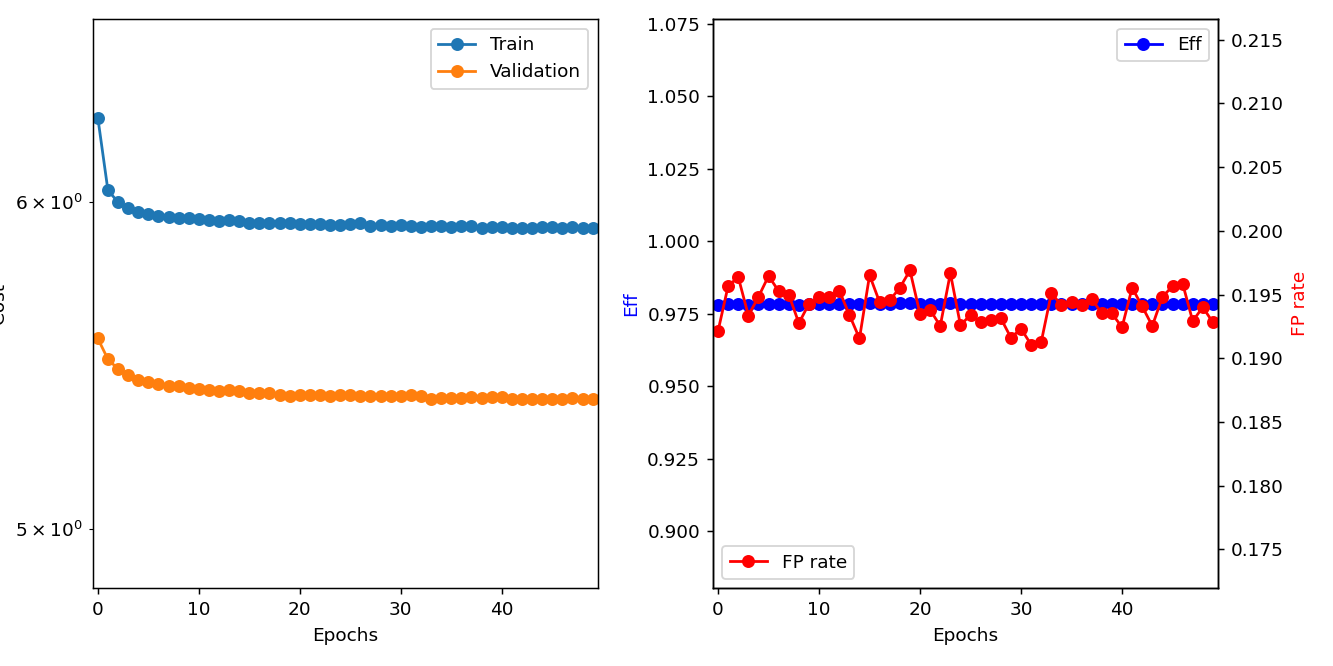

In [14]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [15]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 2032, val = 144


x0 =  tensor([[9.1305e-32, 9.0908e-34, 7.4374e-36,  ..., 1.8294e-27, 9.8852e-28,
         2.7093e-25],
        [1.0269e-25, 9.0159e-32, 3.6580e-40,  ..., 6.2546e-24, 1.8802e-22,
         7.0657e-21],
        [1.8715e-37, 6.4503e-36, 9.3571e-31,  ..., 6.9612e-21, 1.7597e-25,
         5.9086e-26],
        ...,
        [1.0445e-36, 7.4734e-41, 1.1771e-43,  ..., 1.9374e-20, 1.6844e-12,
         4.4162e-18],
        [7.6628e-34, 2.7933e-35, 6.2557e-36,  ..., 2.5227e-26, 7.8683e-24,
         5.6505e-21],
        [5.6767e-42, 2.8026e-45, 0.0000e+00,  ..., 3.3767e-30, 1.6854e-30,
         5.4249e-29]], device='cuda:0', grad_fn=<SoftplusBackward>)
x1 =  tensor([[ 0.0507,  0.0289,  0.0048,  ..., -0.0717, -0.0427, -0.0165],
        [-0.0678, -0.0927, -0.1204,  ..., -0.0102,  0.0131,  0.0276],
        [ 0.0973,  0.0982,  0.0990,  ..., -0.0214,  0.0038,  0.0325],
        ...,
        [ 0.1016,  0.1015,  0.1015,  ...,  0.0525,  0.0689,  0.0768],
        [-0.0329, -0.0713, -0.1237,  ..., -0.0698, -0.

Epoch 1: train=6.03811, val=5.49526, took 95.383 s
  Validation Found 91848 of 93880, added 3591 (eff 97.84%) (0.196 FP/event)


Epoch 2: train=5.99857, val=5.46531, took 94.344 s
  Validation Found 91846 of 93880, added 3603 (eff 97.83%) (0.196 FP/event)


Epoch 3: train=5.97996, val=5.44717, took 94.954 s
  Validation Found 91826 of 93880, added 3548 (eff 97.81%) (0.193 FP/event)


Epoch 4: train=5.96544, val=5.43266, took 95.085 s
  Validation Found 91840 of 93880, added 3575 (eff 97.83%) (0.195 FP/event)


Epoch 5: train=5.95939, val=5.42593, took 95.368 s
  Validation Found 91849 of 93880, added 3605 (eff 97.84%) (0.196 FP/event)


Epoch 6: train=5.95231, val=5.42053, took 95.47 s
  Validation Found 91840 of 93880, added 3583 (eff 97.83%) (0.195 FP/event)


Epoch 7: train=5.94851, val=5.41401, took 95.637 s
  Validation Found 91835 of 93880, added 3578 (eff 97.82%) (0.195 FP/event)


Epoch 8: train=5.9449, val=5.41467, took 95.823 s
  Validation Found 91823 of 93880, added 3537 (eff 97.81%) (0.193 FP/event)


Epoch 9: train=5.94478, val=5.4075, took 96.146 s
  Validation Found 91830 of 93880, added 3565 (eff 97.82%) (0.194 FP/event)


Epoch 10: train=5.94283, val=5.40598, took 95.9 s
  Validation Found 91835 of 93880, added 3574 (eff 97.82%) (0.195 FP/event)


Epoch 11: train=5.93896, val=5.40122, took 95.925 s
  Validation Found 91842 of 93880, added 3574 (eff 97.83%) (0.195 FP/event)


Epoch 12: train=5.9354, val=5.39865, took 95.774 s
  Validation Found 91840 of 93880, added 3584 (eff 97.83%) (0.195 FP/event)


Epoch 13: train=5.93717, val=5.40103, took 95.313 s
  Validation Found 91842 of 93880, added 3549 (eff 97.83%) (0.193 FP/event)


Epoch 14: train=5.93418, val=5.39942, took 95.671 s
  Validation Found 91830 of 93880, added 3515 (eff 97.82%) (0.192 FP/event)


Epoch 15: train=5.93026, val=5.39184, took 96.517 s
  Validation Found 91874 of 93880, added 3606 (eff 97.86%) (0.197 FP/event)


Epoch 16: train=5.92973, val=5.39259, took 96.133 s
  Validation Found 91850 of 93880, added 3567 (eff 97.84%) (0.194 FP/event)


Epoch 17: train=5.9282, val=5.39123, took 95.445 s
  Validation Found 91861 of 93880, added 3570 (eff 97.85%) (0.195 FP/event)


Epoch 18: train=5.92907, val=5.38728, took 95.631 s
  Validation Found 91866 of 93880, added 3588 (eff 97.85%) (0.196 FP/event)


Epoch 19: train=5.92854, val=5.3826, took 95.47 s
  Validation Found 91874 of 93880, added 3613 (eff 97.86%) (0.197 FP/event)


Epoch 20: train=5.92405, val=5.38715, took 95.438 s
  Validation Found 91844 of 93880, added 3550 (eff 97.83%) (0.193 FP/event)


Epoch 21: train=5.92521, val=5.38712, took 95.431 s
  Validation Found 91859 of 93880, added 3556 (eff 97.85%) (0.194 FP/event)


Epoch 22: train=5.92472, val=5.38705, took 95.354 s
  Validation Found 91849 of 93880, added 3533 (eff 97.84%) (0.193 FP/event)


Epoch 23: train=5.9238, val=5.38243, took 95.648 s
  Validation Found 91863 of 93880, added 3609 (eff 97.85%) (0.197 FP/event)


Epoch 24: train=5.9231, val=5.38617, took 95.575 s
  Validation Found 91858 of 93880, added 3534 (eff 97.85%) (0.193 FP/event)


Epoch 25: train=5.92406, val=5.38514, took 95.498 s
  Validation Found 91858 of 93880, added 3549 (eff 97.85%) (0.193 FP/event)


Epoch 26: train=5.92763, val=5.38368, took 95.461 s
  Validation Found 91855 of 93880, added 3538 (eff 97.84%) (0.193 FP/event)


Epoch 27: train=5.91788, val=5.38229, took 95.434 s
  Validation Found 91853 of 93880, added 3541 (eff 97.84%) (0.193 FP/event)


Epoch 28: train=5.92377, val=5.3842, took 95.263 s
  Validation Found 91850 of 93880, added 3544 (eff 97.84%) (0.193 FP/event)


Epoch 29: train=5.9203, val=5.38224, took 95.638 s
  Validation Found 91843 of 93880, added 3516 (eff 97.83%) (0.192 FP/event)


Epoch 30: train=5.92278, val=5.38364, took 95.519 s
  Validation Found 91841 of 93880, added 3529 (eff 97.83%) (0.192 FP/event)


Epoch 31: train=5.91732, val=5.38614, took 95.638 s
  Validation Found 91832 of 93880, added 3506 (eff 97.82%) (0.191 FP/event)


Epoch 32: train=5.91612, val=5.38303, took 95.694 s
  Validation Found 91833 of 93880, added 3510 (eff 97.82%) (0.191 FP/event)


Epoch 33: train=5.92018, val=5.37604, took 95.329 s
  Validation Found 91859 of 93880, added 3580 (eff 97.85%) (0.195 FP/event)


Epoch 34: train=5.92055, val=5.378, took 95.513 s
  Validation Found 91856 of 93880, added 3563 (eff 97.84%) (0.194 FP/event)


Epoch 35: train=5.91705, val=5.37897, took 95.468 s
  Validation Found 91853 of 93880, added 3567 (eff 97.84%) (0.194 FP/event)


Epoch 36: train=5.91785, val=5.37855, took 95.415 s
  Validation Found 91843 of 93880, added 3563 (eff 97.83%) (0.194 FP/event)


Epoch 37: train=5.91856, val=5.37934, took 95.706 s
  Validation Found 91855 of 93880, added 3572 (eff 97.84%) (0.195 FP/event)


Epoch 38: train=5.9131, val=5.3765, took 96.129 s
  Validation Found 91845 of 93880, added 3551 (eff 97.83%) (0.194 FP/event)


Epoch 39: train=5.91633, val=5.3796, took 95.827 s
  Validation Found 91841 of 93880, added 3551 (eff 97.83%) (0.194 FP/event)


Epoch 40: train=5.91528, val=5.38047, took 95.876 s
  Validation Found 91845 of 93880, added 3531 (eff 97.83%) (0.192 FP/event)


Epoch 41: train=5.91362, val=5.37476, took 95.659 s
  Validation Found 91858 of 93880, added 3588 (eff 97.85%) (0.196 FP/event)


Epoch 42: train=5.91344, val=5.37566, took 95.342 s
  Validation Found 91846 of 93880, added 3561 (eff 97.83%) (0.194 FP/event)


Epoch 43: train=5.91134, val=5.37502, took 95.67 s
  Validation Found 91846 of 93880, added 3533 (eff 97.83%) (0.193 FP/event)


Epoch 44: train=5.91476, val=5.37532, took 95.587 s
  Validation Found 91851 of 93880, added 3575 (eff 97.84%) (0.195 FP/event)


Epoch 45: train=5.91439, val=5.37356, took 95.533 s
  Validation Found 91852 of 93880, added 3590 (eff 97.84%) (0.196 FP/event)


Epoch 46: train=5.91274, val=5.37383, took 95.639 s
  Validation Found 91861 of 93880, added 3594 (eff 97.85%) (0.196 FP/event)


Epoch 47: train=5.91506, val=5.37631, took 95.512 s
  Validation Found 91843 of 93880, added 3540 (eff 97.83%) (0.193 FP/event)


Epoch 48: train=5.9123, val=5.37355, took 95.606 s
  Validation Found 91853 of 93880, added 3560 (eff 97.84%) (0.194 FP/event)


Epoch 49: train=5.91251, val=5.37539, took 95.308 s
  Validation Found 91850 of 93880, added 3538 (eff 97.84%) (0.193 FP/event)



# Results

Let's save some results: (even though if you have not changed the code above, it saves the model every epoch)

Go ahead and save the final model (even though it was also saved above):

In [16]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [17]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/data/conda/envs/goofit/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


Save the plot above:

<IPython.core.display.Javascript object>


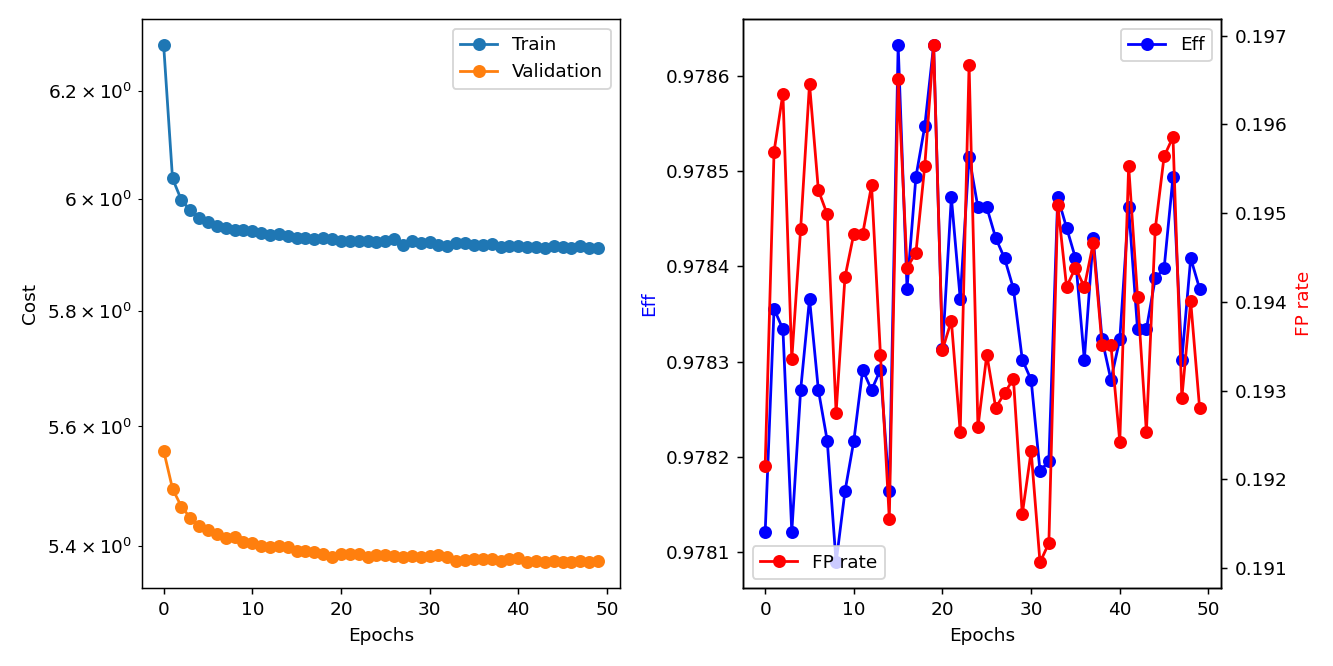

In [18]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [20]:
##quit()